***Adsorción de aguas grises con lecho fijo de carbón activado***

La siguiente ecuación modela la adsorción no estacionaria, despreciando la difusión como mecanismo de transferencia de masa y considerando la convección y acumulación del contaminante de interés tanto en el adsorbedor (W) como en la fase fluida (c):
\begin{equation}
\epsilon\frac{\partial c}{\partial t} + \rho_p (1 - \epsilon)\frac{\partial W}{\partial t}  = -u_o \frac{\partial c}{\partial z}
\end{equation}
Se usa la siguiente ecuación para establecer una relación entre la concentración de la fase fluida y el adsorbente:
$$\rho_p (1 - \epsilon)\frac{\partial W}{\partial t}  = K_c a (c - c^*)$$

Resulta la siguiente ecuación principal:
$$\epsilon\frac{\partial c}{\partial t} +  K_c a (c - c^*) = -u_o \frac{\partial c}{\partial z}$$

En este caso se resuelve con $c^* = 0$, ya que se considera adsorción irreversible:
$$\epsilon\frac{\partial c}{\partial t} +  K_c a c = -u_o \frac{\partial c}{\partial z}$$

$$\frac{\partial c}{\partial t} =  -\frac{K_c a}{\epsilon} c  - \frac{u_o}{\epsilon} \frac{\partial c}{\partial z}$$

Luego se discretiza el término espacial usando diferencias finitas para aplicar el método de líneas, en el caso del término convectivo se usaron diferencias finitas de primer orden hacia atrás:
$$\frac{\partial c }{\partial t}  = - \frac{K_c a c_i}{\epsilon} - \frac{u_o}{\epsilon} \frac{c_{i} - c_{i - 1}}{\Delta z} $$

Con esta discretización se busca poder transformar un *EDP* en varias *EDO* que serán resueltas simultáneamente

**Condición de borde:**\
Al inicio del lecho se recibe la aproximadamente la misma concentración inicial del contaminante de interés
$$ c(t, z = 0) = c_0, \forall t $$
$$ \frac{\partial c}{\partial t} (t, z = 0) = 0$$

**Condición inicial:**\
En el tiempo inicial todo el lecho (con la excepción del inicio de este) se encuentra libre de contaminante
$$ c(t = 0, z) =  0, \forall z > 0$$





**Importación de Paquetes**

In [2]:
using DifferentialEquations
using Plots

**Función de adsorción**

In [3]:
function adsorption(dc,c,params,t)

    #Parámetros.
    ϵ, u_0 , K_ca , Δz, c_0 = params;

    #Condición de borde para nodo límite izquierdo
    dc[1] = 0

    #Nodos interiores
    for i in 2:(length(c))
        dc[i] = -(K_ca*Δz + u_0)/(ϵ*Δz)*c[i] + (u_0)/(ϵ*Δz)*c[i-1];
    end 
end

adsorption (generic function with 1 method)

**Función para condición inicial**\
Para la implementación de este método es necesario crear una función inicial que entregue un vector con los valores iniciales para cada discretización del la variable $z$

In [4]:
function cond_ini(c_0,z)
    c_inicial = zeros(length(z)); # Vector cero de largo a la dimensión de z
    c_inicial[1] = c_0; # Condición de borde
    return c_inicial
end

cond_ini (generic function with 1 method)

**Parámetros**

In [5]:
Kc = 1e-7 # funciona

ϵ = 0.5 # (Clase 18 OO.UU2)

Dp = 1/1000 #m Jjagwe et al. (2021)

a = 6*(1 - ϵ)/Dp # m^-1  (Clase 18 OO.UU2)

K_ca = Kc*a
#K_ca = 1e-2 # s^-1 

L = 0.1 #m 

Q = 20/60/1000 #m^3/s (Manual de aguas grises de IPCh)
d = 150/1000 #m (Manual de aguas grises de IPCh)
A = d^2/4*pi #m^2 

u_0 = Q/A; #m/s
#u_0 =176.835/100/3600

c_0 = 320/1000; # kg/m^3 Atesci et al. (2023)

ρ_p = 0.7*1000; # kg/m^3 (Clase 18 OO.UU2)



***Implementación del método***

In [6]:
N = 100 # Número de nodos
Δz = L/N; # Espaciamiento discreto entre los nodos
z = 0:Δz:L; # Arreglo para la discretización del término espacil

t_end = 1*3600  # Tiempo total de implementación (s)

3600

In [7]:
params = [ϵ, u_0, K_ca, Δz, c_0];
c_ini = cond_ini(c_0,z);    
t_span = (0,t_end);

#Se define el problema
prob = ODEProblem(adsorption, c_ini, t_span, params);

# Resolver la EDO
sol = solve(prob);

**Creación de Gráficos**   

In [18]:
#Curva de ruptura
c = sol.u

c_out = [c[i][end] for i in 1:length(c)] #recopilar el último valor para cada tiempo

n = length(c_out);
Δt = t_end/(n-1);
t_axis = [Δt*i/3600 for i in 0:n-1]; #creación de arreglo de tiempo en horas

plot(t_axis,c_out, xlimits=(0,0.0055), ylimits=(0,c_0+0.05),title = "Curva de ruptura",
xlabel = "tiempo (h)", ylabel = "Concentración (kg/m3)")
savefig("Curva_ruptura_c.pdf")

"c:\\Users\\jbega\\OneDrive\\Escritorio\\IPRE INVIERNO 2025\\Curva_ruptura_c.pdf"

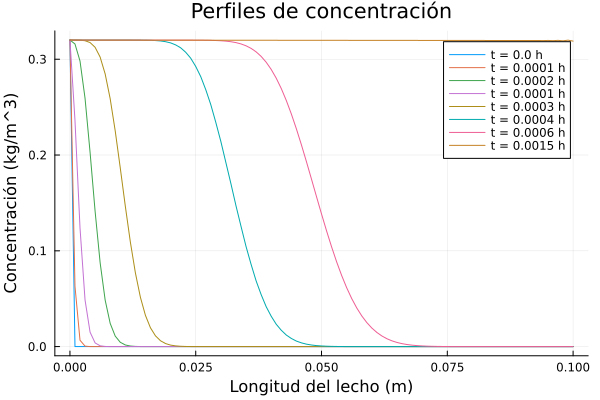

In [10]:
#Perfiles de Concentración en fase fluida a lo largo del lecho

ind = [1,5, 15 ,10, 20, 30, 40 ,100]

plot()  # iniciar gráfico 

#graficar perfil para cada tiempo
for i in ind
    a = round(t_axis[i]; digits = 4)
    plot!(z, c[i], label = "t = $a h")
end

xlabel!("Longitud del lecho (m)")
ylabel!("Concentración (kg/m^3)")
title!("Perfiles de concentración")
#savefig("perfiles_concentracion_c.pdf")

**Implementación de W**

Se usa la siguiente relación para obtener la función de concentración de contaminante en el adsorbedor
$$\frac{\partial W}{\partial t} = \frac{K_c a}{\rho_p (1 - \epsilon)} \left(c\right)$$

In [11]:
function adsorption_W(dW,W,params,t)

    #Parámetros.
    ϵ, u_0 , K_ca , Δz, c_0, ρ_p, c = params;

    #Nodos interiores
    for i in 1:(length(W))
        dW[i] = K_ca/(ρ_p*(1 - ϵ))*c[i];
    end
    
end

adsorption_W (generic function with 1 method)

In [12]:
#Condición inicial
function cond_ini_W(c_0,z)
    W_inicial = zeros(length(z)); 
    return W_inicial
end

cond_ini_W (generic function with 1 method)

In [13]:
params_W = [ϵ, u_0 , K_ca , Δz, c_0, ρ_p, c];
c_ini_W = cond_ini_W(c_0,z);    
t_span = (0,t_end);

#Se define el problema
prob_W = ODEProblem(adsorption_W, c_ini_W, t_span, params_W);

# Resolver la ODE
sol_W = solve(prob);

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\jbega\.julia\packages\SciMLBase\THas4\src\performance_warnings.jl:33


In [14]:
W = sol_W.u

W_out = [sol_W[i][end] for i in 1:length(sol_W)]
n_W = length(W_out);
Δt = t_end/(n_W-1);
t_axis = [Δt*i/3600 for i in 0:n_W-1]; #en horas

plot(t_axis,W_out, xlimits=(0,0.01), ylimits=(0,c_0),title = "Curva de W",
xlabel = "tiempo (h)", ylabel = "Concentración (kg/kg)")

savefig("CurvaRup_W.pdf")

"c:\\Users\\jbega\\OneDrive\\Escritorio\\IPRE INVIERNO 2025\\CurvaRup_W.pdf"